In [1]:
# sheet started on 12/11/2017 M

#  Analyzing results from the 2013 St George Marathon (Utah)



The St George (SG) Marathon, known for its downhill course profile, is held annually in early October.

I've written __[a](https://dunkemo.wordpress.com/2017/08/14/st-georges-course-profile-and-conservative-starts/)__ __[few](https://dunkemo.wordpress.com/2017/08/17/st-george-conservative-starts-part-2/)__ blog posts about this race, in this particular year, to show that it routinely has extreme numbers of negative splits (NSs).

A professional runner (and statistics professor) wrote his master's thesis in 2015 about marathon pacing and he used 2013 SG results as his dataset. (I've also __[blogged](https://dunkemo.wordpress.com/2017/08/14/the-essence-of-a-running-nerds-masters-thesis-on-marathon-pacing/)__ about what I know regarding his thesis.)

I scraped the results into an XLSX file. The authentic race data can be found online at the following URLs --

http://results.xacte.com/?id=167 (directly to 2013 SG)

http://live.xacte.com/stgeorge/ (SG from 2009 to the present)

https://stgeorgemarathon.com/results.php (SG site)

In [2]:
# import modules

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import re
import unicodedata
import itertools
from helperFunctions import BQlookup2, get_sec, get_time, getDivision, addColumns2, raceFullStats_DF

In [3]:
# In this block, I'm setting up variables to hold the timing mat locations.
# "tenK" and "halfway" are the names of the columns that contain split times at 10K & halfway
# "tenK" will be used shortly when splitting runners into "easy" & "hard" categories
# "halfway" will be used quite often
marDist = 26.21875 # marathon distance in miles
fiveK = 3.106856 # 5 kilometers in miles
halfDist = 0.5*marDist # half marathon distance in miles

mats = [fiveK*2, halfDist, fiveK*6, marDist] # 10K, half, 30K, finish

timingmats = {}
for i in range(len(mats)):
    timingmats.update({i+1:mats[i]})

findhalf = [abs(x - 0.5*marDist) for x in mats]
halfway_index = (findhalf.index(min(findhalf))) # 1 if 'split2_time', 2 if 'split3_time', etc
halfway = "split" + str(halfway_index+1) + "_time"
findtenK = [abs(x - fiveK*2) for x in mats]
tenK_index = (findtenK.index(min(findtenK)))
tenK = "split" + str(tenK_index+1) + "_time"
print(tenK)
print(halfway)

split1_time
split2_time


In this file, you'll be seeing a lot of the *split2_time* column.

This is because we're very interested in how people slow down or speed up after halfway (i.e., whether they positive-split or negative-split).

Oftentimes, we'll be looking at *split2_time* with *2ndhalf* side-by-side, along with *splits* (*2ndhalf - split2_time*, in seconds) or *splits_t* (*2ndhalf - split2_time*, in (+/-)MM:SS format)

In [4]:
# data import (and cleaning!!)

filename = "2013stgeorge_gh.xlsx"
dfr = pd.read_excel(filename)
ageUp = True
dfr.rename(columns = {'finish_guntime': 'gun',
                      'finish_time': 'chip',
                      'finish_chiptime': 'chip',
                      'chip_time': 'chip',
                      'place_y': 'place'}, inplace=True)
dfr = dfr[dfr.chip.notnull()]
dfr = dfr[~dfr.chip.str.isspace()]
dfr = dfr[~dfr.chip.isin(["DNF","-DNF-","DNS","DQ","DSQ","00:00:00","0:00:00"])]

dfr.reset_index(drop=True,inplace=True)
dfr['name'].replace(np.nan,u'UNKNOWN',inplace=True)
dfr['name'] = dfr.apply(lambda row: unicodedata.normalize('NFD', row['name']).encode('ascii', 'ignore'),axis=1)
dfr['name'] = dfr.name.str.replace("\.","").str.strip()
dfr.columns = [x.replace("_chiptime","_time") for x in dfr.columns]

for x in [('split'+str(y)+'_time') for y in range(1,len(mats))]:
    dfr[x].replace("00:00:00","",inplace=True)
    dfr[x].replace("-","",inplace=True)
    dfr[x].replace(regex=r'\s+',value="",inplace=True)
    dfr[x].replace(np.nan,"",inplace=True)
    dfr[x] = dfr.apply(lambda row: row[x] if "Predicted" not in row[x] else "", axis=1)

print(len(dfr))

5818


In [5]:
print(len(dfr.columns))
dfr.columns

26


Index([u'place', u'bib', u'name', u'age', u'sex', u'city', u'chip', u'gun',
       u'split1_time', u'split2_time', u'split3_time', u'split1_guntime',
       u'split2_guntime', u'split3_guntime', u'split1_tod', u'split2_tod',
       u'split3_tod', u'finish_tod', u'split1_pace', u'split2_pace',
       u'split3_pace', u'pace', u'int1_pace', u'int2_pace', u'int3_pace',
       u'int4_pace'],
      dtype='object')

In [6]:
dfr.head()

,place,bib,name,age,sex,city,chip,gun,split1_time,split2_time,...,split3_tod,finish_tod,split1_pace,split2_pace,split3_pace,pace,int1_pace,int2_pace,int3_pace,int4_pace
0,1,6,BRYANT JENSEN,30,M,"OGDEN, UT",2:15:56,2:20:23,32:18,1:08:38,...,8:26:10,9:05:23,5:12,5:14,5:11,5:11,5:12,5:16,5:04,5:10
1,2,1,FRITZ VAN DE KAMP,33,M,"MILLCREEK, UT",2:20:25,2:24:51,32:24,1:10:51,...,8:28:44,9:09:51,5:12,5:24,5:19,5:21,5:12,5:34,5:08,5:25
2,3,2,JONATHAN KOTTER,28,M,"SLC, UT",2:20:50,2:25:16,33:23,1:12:57,...,8:29:56,9:10:16,5:22,5:33,5:23,5:22,5:22,5:44,4:58,5:19
3,4,3,IAIN HUNTER,42,M,"PROVO, UT",2:20:53,2:25:19,33:23,1:11:52,...,8:30:04,9:10:19,5:22,5:28,5:23,5:22,5:22,5:34,5:12,5:18
4,5,14,ZAK JAMES,36,M,"OREM, UT",2:21:49,2:26:16,33:22,1:12:02,...,8:30:05,9:11:16,5:22,5:29,5:23,5:24,5:22,5:36,5:10,5:26


In [7]:
dfr = addColumns2(dfr, 'chip','sex','age', ageUp, mats) # age_up is 5th input
# Because 2013 SG is a qualfier for 2015 Boston, all runners "age up" a year.
# For example, this means that a 34-year-old has a BQ requirement of a 35-year-old.
# addColumns2 calculates split paces, BQ reqs, splits, stdpace, and many other metrics.
# a pink RuntimeWarning box might appear directly below --
#  (when calculating stdpace, some runners have no split times, and therefore stdpace=NaN)

5818 records
32.2128204141 (median stdpace)
2:21 (median splits)


/Users/donwang/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [8]:
print(len(dfr.columns))
dfr.columns

61


Index([                      u'place',                         u'bib',
                              u'name',                         u'age',
                               u'sex',                        u'city',
                              u'chip',                         u'gun',
                       u'split1_time',                 u'split2_time',
                       u'split3_time',              u'split1_guntime',
                    u'split2_guntime',              u'split3_guntime',
                        u'split1_tod',                  u'split2_tod',
                        u'split3_tod',                  u'finish_tod',
                       u'split1_pace',                 u'split2_pace',
                       u'split3_pace',                        u'pace',
                         u'int1_pace',                   u'int2_pace',
                         u'int3_pace',                   u'int4_pace',
                           u'seconds',                       u'BQreq',
      

In [9]:
dfr.describe()

/Users/donwang/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,place,bib,age,seconds,BQ,epoch,BQpace_sec,split1_score,split2_score,split3_score,BQdiff,2ndhalfpace,1sthalfpace,pace_diff,splits,mm_len,stdpace,pacesdiff,biggestslowdown,slowest_split
count,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5791.000000,5787.000000,5796.000000,5818.000000,5787.000000,5787.000000,5787.000000,5787.000000,5818.000000,5809.000000,5809.000000,5818.000000,5818.000000
mean,2909.500000,4258.539017,40.716913,15385.119285,0.216226,719163.178069,488.004225,56.583667,85.923798,86.040204,2590.258508,599.247958,573.940155,25.307803,331.769483,0.013750,43.351072,109.165074,2.825885,3.013750
std,1679.656264,2579.178801,11.421148,3159.991574,0.411705,0.036574,46.319765,91.901479,103.159735,108.762922,3074.837154,138.601997,107.657182,60.063732,787.397990,0.161063,33.477722,82.901889,0.991508,1.023944
min,1.000000,1.000000,8.000000,8156.000000,0.000000,719163.094398,423.361144,-220.884969,-138.145411,-146.485724,-3979.000000,308.023838,314.126341,-293.072706,-3842.000000,0.000000,1.696353,0.000000,0.000000,0.000000
25%,1455.250000,1969.250000,33.000000,13095.250000,0.000000,719163.151565,446.245530,NaN,NaN,NaN,289.250000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,2.000000,2.000000
50%,2909.500000,3949.000000,40.000000,14861.000000,0.000000,719163.172002,492.014303,NaN,NaN,NaN,2006.500000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,2.000000,4.000000
75%,4363.750000,6602.500000,49.000000,17262.000000,0.000000,719163.199792,514.898689,NaN,NaN,NaN,4411.500000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4.000000,4.000000
max,5818.000000,8615.000000,81.000000,26509.000000,1.000000,719163.306817,709.415971,441.373504,475.537545,529.155913,14024.000000,1164.433850,970.221692,470.579261,6169.000000,3.000000,318.457599,831.107427,4.000000,4.000000


### Preliminary exploratory data analysis

In [10]:
pd.set_option('max_colwidth',120)

dfrFULL = raceFullStats_DF(dfr,'sex','age')
dfrFULL

,#_run,#_BQs,BQ%,BQ_time,Min_time,Med_time,Mean_time,Max_time
Age_Group,,,,,,,,
F0-34,972,157,16.2%,3:35,2:40:04,4:20:42,4:29:25,7:21:49
F35-39,551,144,26.1%,3:40,2:37:08,4:10:11,4:17:07,6:56:22
F40-44,433,104,24.0%,3:45,2:48:39,4:13:50,4:25:58,7:17:29
F45-49,261,84,32.2%,3:55,2:53:47,4:14:38,4:22:00,7:01:56
F50-54,228,73,32.0%,4:00,3:07:54,4:26:06,4:35:05,7:16:53
F55-59,124,33,26.6%,4:10,3:21:09,4:41:15,4:46:36,6:46:34
F60-64,68,24,35.3%,4:25,3:18:41,4:55:30,4:54:58,6:54:41
F65-69,11,2,18.2%,4:40,3:57:07,4:54:05,5:12:48,6:55:27
F70-74,3,0,0.0%,4:55,4:55:16,5:37:14,5:36:57,6:18:23


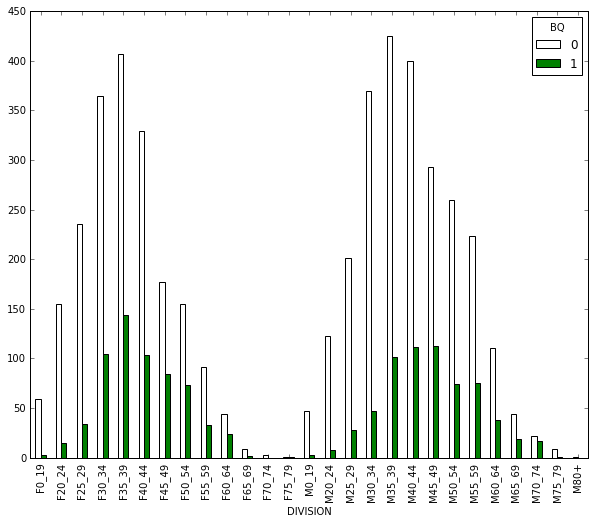

In [11]:
# plot histogram of AGs & BQs
AGbqs = pd.pivot_table(dfr, columns='BQ', values='bib', index ='DIVISION', aggfunc=len)
AGbqs.plot(kind='bar',stacked=False,color = ['white','green'], figsize=[10,8])
plt.show()

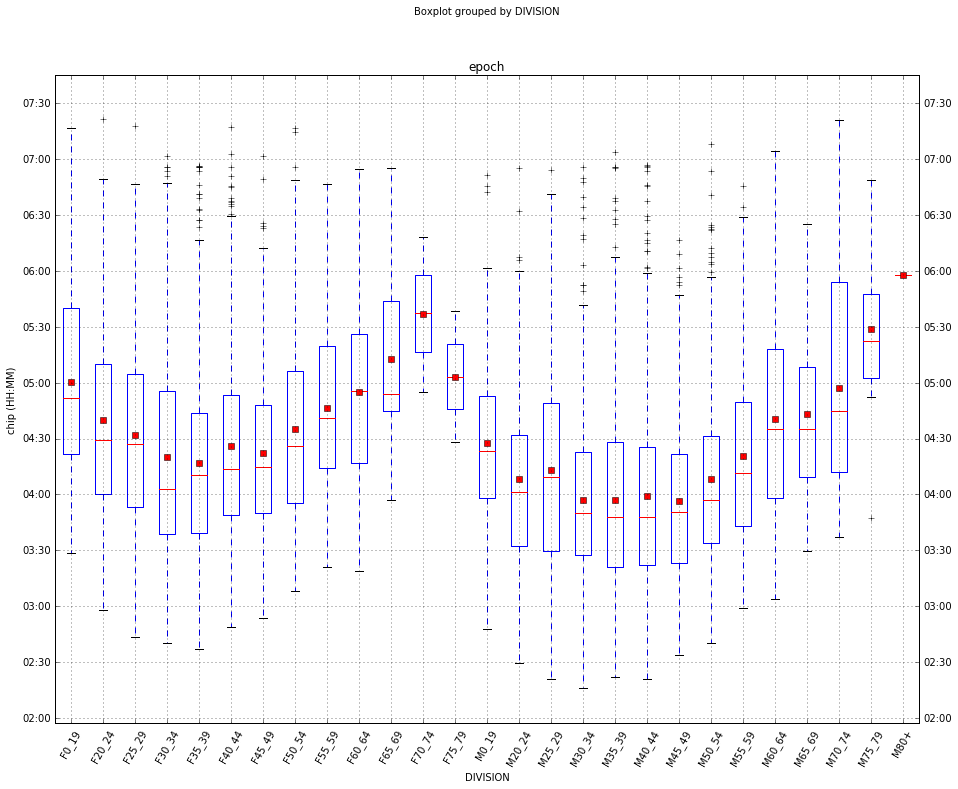

In [12]:
ax = dfr.boxplot(column='epoch',by='DIVISION',figsize=(15,12),rot=60, showmeans=True)
yformatter = mdates.DateFormatter('%H:%M')
ylocator = mdates.MinuteLocator(byminute=[0,30], interval = 1)

## Set ytick labels to appear every 30 minutes
ax.yaxis.set_major_locator(ylocator)
ax.tick_params(labeltop=False, labelright=True)

## Format ytick labels as HH:MM
plt.gcf().axes[0].yaxis.set_major_formatter(yformatter)
plt.ylabel('chip (HH:MM)')
plt.ylim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(60*60*7.75)])
plt.show()

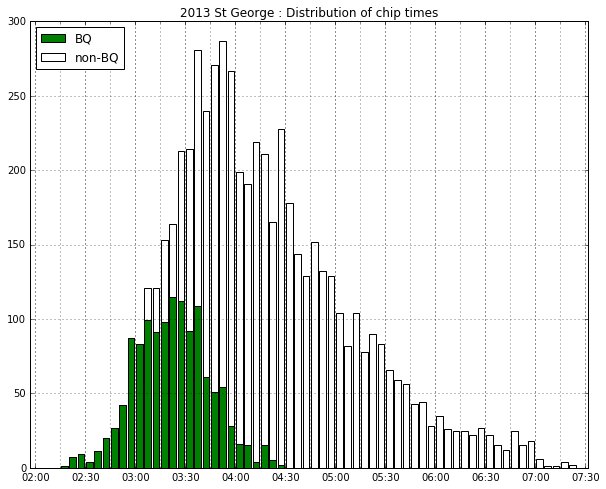

In [13]:
# plot histogram of finish times, with bin sizes of 5 minutes !!

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.hist([dfr[(dfr.BQ==1)]['epoch'],dfr[(dfr.BQ==0)]['epoch']], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    stacked=True, color = ['green','white'], histtype='bar',align='mid',label=['BQ','non-BQ'])
ymax = max(ax.get_ylim())
xmax = dfr.seconds.max() + 60*10

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')
plt.legend(loc='upper left')
plt.title("2013 St George : Distribution of chip times")
plt.xlim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(xmax)])
plt.show()

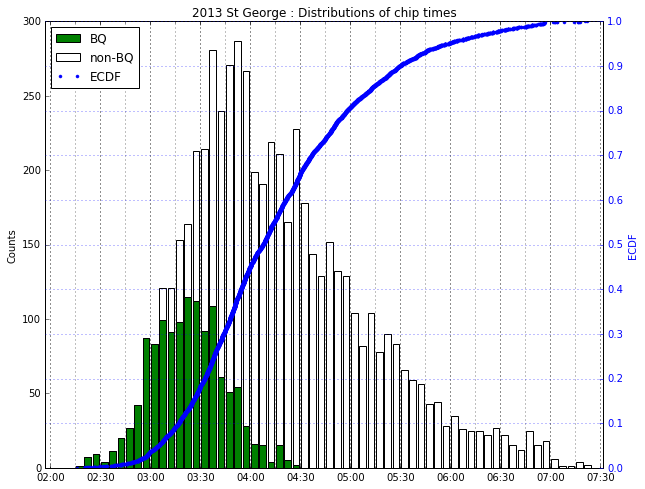

In [14]:
# we can add an ECDF (empirical cumulative distribution function) to the above plot

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.hist([dfr[(dfr.BQ==1)]['epoch'],dfr[(dfr.BQ==0)]['epoch']], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    stacked=True, color = ['green','white'], histtype='bar',align='mid',label=['BQ','non-BQ'])
ymax = max(ax.get_ylim())
xmax = dfr.seconds.max() + 60*10

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
ax.set_ylabel('Counts', color='k')
ax.grid(which='both',axis='x')

# add ECDF
ax2 = ax.twinx()
x = dfr.epoch
y = np.arange(1, len(x)+1)*1.0/len(x)
ax2.plot(x,y, marker='.', linestyle='none',label='ECDF')
ax2.set_ylabel('ECDF', color='b')
ax2.yaxis.set_ticks(np.arange(0, 1.1, 0.1)) # set tick labels at 0.1 steps (default was 0.2)
ax2.tick_params('y', colors='b')
ax2.grid(which='both',axis='y', color='b')

# make sure that legend has entries from both ax & ax2
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.title("2013 St George : Distributions of chip times")
plt.xlim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(xmax)])
plt.show()

With the above, we can visually verify that the median time is in the 4:10-4:15 bin (by where the string of blue dots crosses the 0.5 dotted line on the secondary y-axis).

A runner would have had to finish in the 3:15-3:20 range to be in the top 10%.

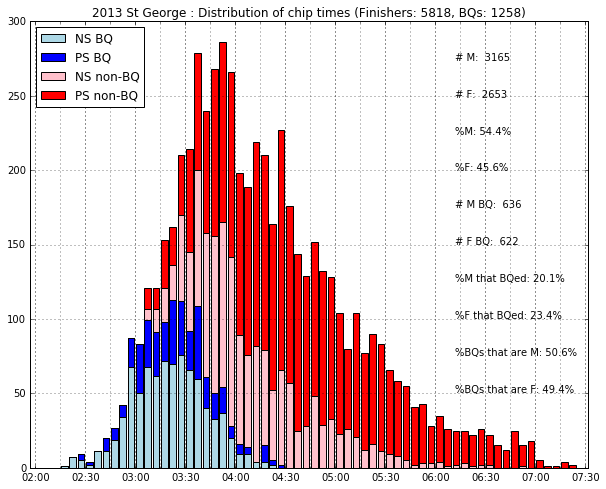

In [15]:
# re-draw the above histogram, but add more details

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.hist([dfr[(dfr.BQ==1) & (dfr.splits<0)]['epoch'],dfr[(dfr.BQ==1) & (dfr.splits>=0)]['epoch'],dfr[(dfr.BQ==0) & (dfr.splits<0)]['epoch'],dfr[(dfr.BQ==0) & (dfr.splits>=0)]['epoch']], 
         bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), stacked=True, color = ['lightblue','blue','pink','red'], histtype='bar',align='mid',label=['NS BQ','PS BQ','NS non-BQ', 'PS non-BQ'])
ymax = max(ax.get_ylim())
xmax = dfr.seconds.max() + 60*10
lines_of_text = 12

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')
plt.legend(loc='upper left')
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-1),"# M:  " + str(len(dfr[dfr.sex=='M'])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-2),"# F:  " + str(len(dfr[dfr.sex=='F'])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-3),"%M: {:.1%}".format(len(dfr[(dfr.sex=='M')])*1.0/len(dfr)))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-4),"%F: {:.1%}".format(len(dfr[(dfr.sex=='F')])*1.0/len(dfr)))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-5),"# M BQ:  " + str(len(dfr[(dfr.sex=='M') & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-6),"# F BQ:  " + str(len(dfr[(dfr.sex=='F') & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-7),"%M that BQed: {:.1%}".format(len(dfr[(dfr.sex=='M') & (dfr.BQ==1)])*1.0/len(dfr[dfr.sex=='M'])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-8),"%F that BQed: {:.1%}".format(len(dfr[(dfr.sex=='F') & (dfr.BQ==1)])*1.0/len(dfr[dfr.sex=='F'])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-9),"%BQs that are M: {:.1%}".format(len(dfr[(dfr.sex=='M') & (dfr.BQ==1)])*1.0/len(dfr[dfr.BQ==1])))
plt.text(mdates.epoch2num(xmax-60*80),1+(ymax-2)/lines_of_text*(lines_of_text-10),"%BQs that are F: {:.1%}".format(len(dfr[(dfr.sex=='F') & (dfr.BQ==1)])*1.0/len(dfr[dfr.BQ==1])))
plt.title("2013 St George : Distribution of chip times (Finishers: " + str(len(dfr)) + ", BQs: " + str(len(dfr.query("BQ==1"))) + ")")
plt.xlim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(xmax)])
plt.show()

With the above, we can see that a good portion of all runners ran negative splits, whether or not they BQed.

The numbers in the race stats table higher up are shown on the plot: men outnumbered women at the race (which is generally true at marathons), but women were better at running BQs that day. Women accounted for 49.4% of the BQs even though the race was only 45.6% female.

Next, we split all finishers into "easy" and "hard" groups. (I've written a __[blog post](https://dunkemo.wordpress.com/2017/08/03/easy-vs-hard/)__ about this.)

This is to get a better idea of who are actually trying to run fast and qualify for Boston, out of the 5818 finishers.

### Brief description of metrics, easy/hard

addColumns2 calculated lots of metrics and added lots of columns to the dataframe.

Let's take a look at the frequently reported columns that you'll see in in the rest of the file.

In [16]:
columns_i_want = ['BQ','bib', 'name', 'age','chip',halfway,'2ndhalf','splits','mm','non_missing_splitpaces_time','stdpace']
dfr.sample(5)[columns_i_want]

,BQ,bib,name,age,chip,split2_time,2ndhalf,splits,mm,non_missing_splitpaces_time,stdpace
1917,0,1487,LELAND HOLDENER,51,3:47:27,1:56:50,1:50:37,-373.0,[],"[8:47, 9:02, 8:10, 8:38]",21.778646
5062,0,3536,GLEN KOGA,65,5:19:45,2:25:32,2:54:13,1721.0,[],"[9:49, 12:15, 11:36, 14:32]",116.701106
65,1,90,ERIC J PETERSEN,42,2:48:09,1:26:03,1:22:06,-237.0,[],"[6:20, 6:46, 6:04, 6:24]",17.218071
23,1,131,JOSHUA B EREKSON,36,2:36:41,1:20:21,1:16:20,-241.0,[],"[5:57, 6:17, 5:43, 5:54]",14.313456
4977,0,3265,DORRELL HENDERSON,65,5:14:24,2:34:23,2:40:01,338.0,[],"[11:06, 12:23, 10:42, 13:18]",71.589050


Many of the data fields are self explanatory: BQ, bib, name, age

__*splits*__: difference, in seconds, between a runner's first & second halves of the race (second half minus first half). Positive values indicate a slower second half.

__*mm*__: stands for "missing mats". An empty list indicates no missing splits. A value of, say, [2], means that the 2nd timing mat didn't detect the runner passing through at that location.

__*non_missing_splitpaces_time*__: self explanatory (the _time_ suffix refers to MM:SS time format and is meant to differentiate this from *non_missing_splitpaces* (another column in the dataframe, which has split paces in seconds (floating point, not integers))). If a runner has *mm*=[] (empty list), then the four numbers in *non_missing_splitpaces_time* represent the following: (1) split pace between the start and 10K, (2) split pace between 10K and halfway, (3) split pace between halfway and 30K, and (4) split pace between 30K and the finish. If a runner has *mm*=[3], then the last number in this *non_missing_splitpaces_time* would represent the split pace between halfway and the finish, not the split pace between 30K and the finish.

__*stdpace*__: standard deviation, in seconds, of a runner's split paces. *stdpace* is calculated based on the numbers in *non_missing_splitpaces*. Oftentimes we will sort results by *stdpace* (in descending order) to see cases of extreme pacing fluctuations listed first.

Let's take a look at some more metrics --

In [17]:
columns_i_want = ['BQ','bib', 'name', 'sex','age','BQreq','BQpace','pace','split1_pace','split2_pace','split1_score','split2_score']
dfr.sample(5)[columns_i_want]

,BQ,bib,name,sex,age,BQreq,BQpace,pace,split1_pace,split2_pace,split1_score,split2_score
3994,0,2829,DUSTY V DAVIS,M,58,3:40:00,8:23,10:28,9:30,10:23,66.090339,119.990465
562,1,1000,BARRY D WALLMAN,M,61,3:55:00,8:58,7:29,7:28,7:40,-89.580777,-77.425507
2751,0,6261,JESSICA SANDERSON,F,42,3:45:00,8:35,9:16,8:59,9:16,24.553413,41.497020
2505,0,6298,JANA FOGGIN,F,38,3:40:00,8:23,9:03,8:32,8:49,8.636759,25.249106
1033,1,793,STEVE LING,M,53,3:30:00,8:01,7:59,8:04,8:14,3.357625,13.654350


__BQreq__: a runner's BQ requirement, based on age & sex

__BQpace__: calculated from *BQreq*

__pace__: a runner's overall pace at the finish, calculated from *chip*

__split1_pace/split2_pace/splitX_pace__: a runner's cumulative pace at the timing mat location, calculated from *splitX_time*, rounded from units of seconds/mile to MM:SS format

__split1_score/split2_score/splitX_score__: the difference between *splitX_pace* and *BQpace*, in seconds/mile (unrounded). Negative values indicate that a runner is ahead of BQ pace at that timing mat. (Think of "score" in terms of golf scores: the lower the better, in terms of being ahead of pace for a BQ.)

Below, we see how a runner's "scores" at 10K & halfway determine how they're classified: "easy" (not running fast for a BQ) or "hard" (chasing a BQ) --

In [18]:
# split runners into 2 categories:
# easy -- those not going for BQs 
# (those who didn't BQ, and weren't within 0:20/mi of their BQ pace at both 10K and halfway)
# hard -- those going for BQs

margin = 20 # seconds

easy = dfr[(dfr['BQ'].isin([0]) & 
    ( ((dfr[tenK.replace("time","score")]) > margin) |
    ((dfr[halfway.replace("time","score")]) > margin)  )) |
    (dfr['BQ'].isin([0]) & dfr[tenK.replace("time","score")].isnull() & dfr[halfway.replace("time","score")].isnull()) ]
hard = dfr.ix[(list(set(dfr.index) - set(easy.index)))]
print(len(easy))
print(len(hard))

4089
1729


The margin of 20 seconds was picked arbitrarily, but it seems reasonable. A runner behind BQpace by 0:20/mi at halfway is behind by around 4 minutes and 20 seconds, which means that she would have to run the second half in 8:40 in order to break even and BQ.

My reasoning is that a runner can't be considered to be going "hard" if she's behind by that much at both 10K and halfway.

Next, let's print some stats concerning easy/hard runners --

In [19]:
# some stats comparing easy & hard BQers & hard non-BQers
print("'splits' metric --")
print("{} (everyone)".format(get_time(dfr['splits'].median())))
print("{} (easy)".format(get_time(easy['splits'].median())))
print("{} (hard)".format(get_time(hard['splits'].median())))
print("{} (hard BQs)".format(get_time(hard.query("BQ==1")['splits'].median())))
print("{} (hard non-BQs)".format(get_time(hard.query("BQ==0")['splits'].median())))
print("")
print("'stdpace' metric --")
print("{} (everyone)".format(dfr['stdpace'].median()))
print("{} (easy)".format(easy['stdpace'].median()))
print("{} (hard)".format(hard['stdpace'].median()))
print("{} (hard BQs)".format(hard.query("BQ==1")['stdpace'].median()))
print("{} (hard non-BQs)".format(hard.query("BQ==0")['stdpace'].median()))

'splits' metric --
2:21 (everyone)
4:41 (easy)
-0:25 (hard)
-1:41 (hard BQs)
5:23 (hard non-BQs)

'stdpace' metric --
32.2128204141 (everyone)
40.1648232064 (easy)
20.178240313 (hard)
18.0900208414 (hard BQs)
32.6609318588 (hard non-BQs)


One of the things that J Ward, the professional runner and statistics professor, said about his findings from 2013 SG was that BQ runners varied their paces __*more*__ than non-BQ runners.

The *stdpace* numbers above, however, don't support his argument. (Recall that *stdpace* is the standard deviation of a runner's split paces, and low standard deviation means less variation.)

Let's plot *stdpace* values for "hard" runners only. We've limited the y-axis to 100 --

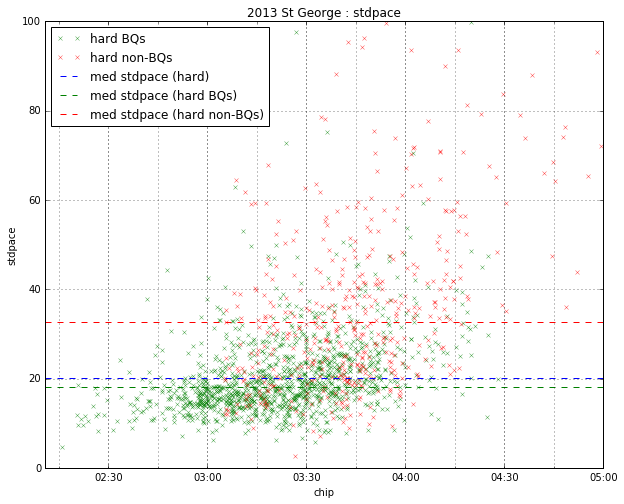

In [20]:
# plotting stdpace by chip time (non-BQ runners have higher stdpace values)
fig, ax = plt.subplots(1,1, figsize=(10,8))

plotx = hard.query("BQ==1")['epoch']
ploty = hard.query("BQ==1")['stdpace']
ax.plot(plotx, ploty, 'gx', aa=True, markersize=4, alpha=0.7, label='hard BQs')

plotx = hard.query("BQ==0")['epoch']
ploty = hard.query("BQ==0")['stdpace']
ax.plot(plotx, ploty, 'rx', aa=True, markersize=4, alpha=0.7, label='hard non-BQs')

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')

plt.title("2013 St George : stdpace")
plt.xlim([mdates.epoch2num(hard.query("BQ==1")['seconds'].min()-60*5),mdates.epoch2num(60*60*5)])
plt.ylim(0,100)
plt.axhline(hard['stdpace'].median(),linestyle='--', color='b', label='med stdpace (hard)')
plt.axhline(hard.query("BQ==1")['stdpace'].median(),linestyle='--', color='g', label='med stdpace (hard BQs)')
plt.axhline(hard.query("BQ==0")['stdpace'].median(),linestyle='--', color='r', label='med stdpace (hard non-BQs)')
plt.legend(loc='upper left')
plt.xlabel('chip')
plt.ylabel('stdpace')
plt.show()

Certainly there are instances where BQ runners have high stdpace values, and non-BQ runners have low stdpace values, but it's clear that most BQ runners had lower stdpace values. Median values don't lie!

We can print additional stats regarding the following: 

-  negative splits
-  all descending/ascending split paces
-  all descending/ascending cumulative paces

In [21]:
print("Negative splits (M): {}".format(len(dfr[(dfr.splits<0) & (dfr.sex=='M')])))
print("Negative splits (F): {}".format(len(dfr[(dfr.splits<0) & (dfr.sex=='F')])))
print("NS BQs (M): {}".format(len(dfr[(dfr.BQ==1) & (dfr.splits<0) & (dfr.sex=='M')])))
print("NS BQs (F): {}".format(len(dfr[(dfr.BQ==1) & (dfr.splits<0) & (dfr.sex=='F')])))
print("")
print("{} all descending split paces".format(((dfr.non_missing_splitpaces == dfr.non_missing_splitpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1))).sum()))
print("{} BQs".format(((dfr.non_missing_splitpaces == dfr.non_missing_splitpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1)) & (dfr.BQ==1)).sum()))
print("{} all ascending split paces".format(((dfr.non_missing_splitpaces == dfr.non_missing_splitpaces.apply(sorted)) & (dfr.mm_len < (len(mats)-1))).sum()))
print("{} BQs".format(((dfr.non_missing_splitpaces == dfr.non_missing_splitpaces.apply(sorted)) & (dfr.mm_len < (len(mats)-1)) & (dfr.BQ==1)).sum()))
print("")
print("{} all descending cumulative paces".format(((dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1))).sum()))
print("{} BQs".format(((dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1)) & (dfr.BQ==1)).sum()))
print("{} all ascending cumulative paces".format(((dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted)) & (dfr.mm_len < (len(mats)-1))).sum()))
print("{} BQs".format(((dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted)) & (dfr.mm_len < (len(mats)-1)) & (dfr.BQ==1)).sum()))

Negative splits (M): 1175
Negative splits (F): 1128
NS BQs (M): 410
NS BQs (F): 430

32 all descending split paces
5 BQs
752 all ascending split paces
17 BQs

122 all descending cumulative paces
25 BQs
2084 all ascending cumulative paces
122 BQs


In [22]:
# number of people with all descending split paces
columns_i_want = ['BQ','name','sex','age','chip','mm','non_missing_splitpaces_time','non_missing_cumpaces']
(dfr.query("biggestslowdown==1")[columns_i_want])
(dfr[(dfr.non_missing_splitpaces == dfr.non_missing_splitpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1))][columns_i_want])
# people with all descending cum paces (some might have all descending split paces too)
#(dfr[(dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1))][columns_i_want])
# people with all descending cum paces (but not all descending split paces)
#(dfr[(dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted,reverse=True)) & (dfr.biggestslowdown!=1) & (dfr.mm_len < (len(mats)-1))][columns_i_want])

,BQ,name,sex,age,chip,mm,non_missing_splitpaces_time,non_missing_cumpaces
41,1,TRENT JENSEN,M,36,2:42:33,[],"[6:25, 6:25, 6:00, 5:58]","[385, 385, 378, 372]"
309,1,MIKE T STRAUSS,M,37,3:05:46,[],"[7:33, 7:30, 6:40, 6:38]","[453, 451, 436, 425]"
702,0,ANDRES PADILLA,M,35,3:20:44,[],"[7:58, 7:57, 7:25, 7:19]","[478, 477, 468, 459]"
877,1,KATIE N GUISINGER,F,33,3:25:43,[],"[8:22, 8:15, 7:25, 7:22]","[502, 498, 482, 471]"
907,0,BENJAMIN W GREENWOOD,M,34,3:26:34,[],"[8:08, 8:03, 7:41, 7:40]","[488, 485, 478, 473]"
929,0,NATHAN J SINGER,M,23,3:27:05,[],"[8:34, 8:30, 7:37, 7:01]","[514, 512, 495, 474]"
1065,0,ADAM D LARSON,M,34,3:30:01,[],"[8:07, 8:06, 8:04, 7:49]","[487, 486, 485, 481]"
1135,0,RYAN A FABER,M,24,3:31:58,[],"[8:46, 8:20, 7:43, 7:34]","[526, 512, 498, 485]"
1353,0,YUN KIM,M,49,3:36:30,[],"[8:46, 8:33, 7:53, 7:51]","[526, 519, 505, 495]"
1431,0,JENNIFER J RICHMOND,F,31,3:37:52,[],"[8:47, 8:38, 7:55, 7:54]","[527, 523, 508, 499]"


### Negative-split BQs

In [23]:
# negative split BQs -- trying to see if it's only super-fast people who can run NS BQs
columns_i_want = ['BQ','bib', 'name', 'age','chip',halfway,'2ndhalf','splits_t','mm','non_missing_splitpaces_time']
nsbq = dfr[(dfr.BQ==1) & (dfr.splits < 0)]
print len(nsbq)
print nsbq['sex'].value_counts()
interval = 1
(dfr.assign(splits_t=map(get_time,dfr.splits))[(dfr.BQ==1) & (dfr.splits < 0)][columns_i_want].sample(10))

840
F    430
M    410
Name: sex, dtype: int64


,BQ,bib,name,age,chip,split2_time,2ndhalf,splits_t,mm,non_missing_splitpaces_time
1046,1,5644,ELISE M WALLACE,31,3:29:45,1:47:13,1:42:32,-4:41,[],"[7:54, 8:26, 7:38, 7:57]"
1322,1,1675,DEAN B ELLIS,54,3:35:49,1:49:38,1:46:11,-3:27,[],"[8:11, 8:32, 8:01, 8:09]"
1015,1,5414,ELIZABETH A LOWES,49,3:29:05,1:47:23,1:41:42,-5:41,[],"[8:01, 8:21, 7:45, 7:46]"
263,1,495,ADAM KLENK,27,3:03:36,1:31:56,1:31:40,-0:16,[],"[6:54, 7:07, 6:39, 7:14]"
84,1,230,LANCE BRADY,42,2:51:30,1:26:56,1:24:34,-2:22,[],"[6:23, 6:52, 6:16, 6:35]"
1572,1,6001,CALLI A GRANT,39,3:40:29,1:54:10,1:46:19,-7:51,[],"[8:29, 8:55, 7:53, 8:16]"
337,1,532,TRAVIS K BLACK,35,3:07:17,1:33:49,1:33:28,-0:21,[],"[7:01, 7:17, 6:54, 7:18]"
426,1,1069,MIKE C SMITH,44,3:10:50,1:37:45,1:33:05,-4:40,[],"[7:13, 7:40, 7:01, 7:10]"
144,1,268,TRACE M LUND,43,2:57:16,1:30:01,1:27:15,-2:46,[],"[6:38, 7:04, 6:33, 6:44]"
756,1,5144,TRACEY A WIGHTMAN ZAHRADKA,43,3:22:41,1:45:17,1:37:24,-7:53,[],"[7:35, 8:26, 7:27, 7:25]"


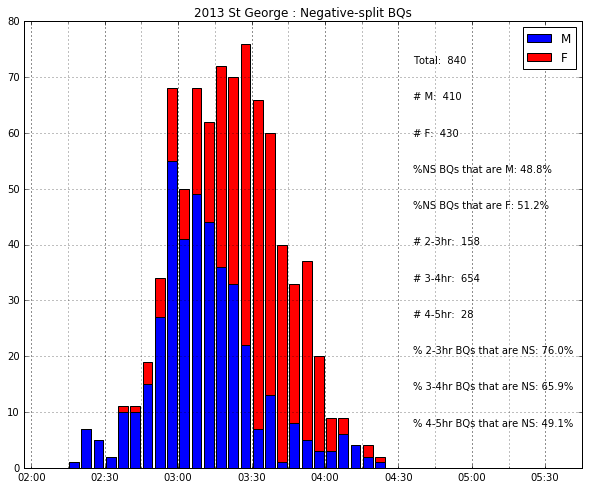

In [24]:
# plotting NS BQs
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.hist([nsbq.query("sex=='M'")['epoch'],nsbq.query("sex=='F'")['epoch']], 
         bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*5.5,60*5)), stacked=True, color = ['blue','red'], histtype='bar',align='mid',label=['M','F'])
ymax = max(ax.get_ylim())
lines_of_text = 12
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-1),"Total:  " + str(len(nsbq)))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-2),"# M:  " + str(len(nsbq[nsbq.sex=='M'])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-3),"# F:  " + str(len(nsbq[nsbq.sex=='F'])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-4),"%NS BQs that are M: {:.1%}".format(len(nsbq[nsbq.sex=='M'])*1.0/len(nsbq)))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-5),"%NS BQs that are F: {:.1%}".format(len(nsbq[nsbq.sex=='F'])*1.0/len(nsbq)))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-6),"# 2-3hr:  " + str(len(nsbq[nsbq.seconds.isin(range(60*60*2,60*60*3))])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-7),"# 3-4hr:  " + str(len(nsbq[nsbq.seconds.isin(range(60*60*3,60*60*4))])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-8),"# 4-5hr:  " + str(len(nsbq[nsbq.seconds.isin(range(60*60*4,60*60*5))])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-9),"% 2-3hr BQs that are NS: {:.1%}".format(len(nsbq[nsbq.seconds.isin(range(60*60*2,60*60*3))])*1.0/len(dfr[dfr.seconds.isin(range(60*60*2,60*60*3)) & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-10),"% 3-4hr BQs that are NS: {:.1%}".format(len(nsbq[nsbq.seconds.isin(range(60*60*3,60*60*4))])*1.0/len(dfr[dfr.seconds.isin(range(60*60*3,60*60*4)) & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-11),"% 4-5hr BQs that are NS: {:.1%}".format(len(nsbq[nsbq.seconds.isin(range(60*60*4,60*60*5))])*1.0/len(dfr[dfr.seconds.isin(range(60*60*4,60*60*5)) & (dfr.BQ==1)])))
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.grid(which='both',axis='both')
plt.legend()
plt.title("2013 St George : Negative-split BQs")
plt.xlim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(60*60*5.75)])
plt.show()

### Comebacks, fades, and the NS/BQ contingency table

In [25]:
# comebacks (those who were behind BQ pace at halfway but BQed)
# (sorted by halfway score, or how far behind they are at halfway)
columns_i_want = ['BQ','bib','name','age',halfway.replace("time","score"),'BQreq','chip',halfway,'2ndhalf','splits_t','behindby','BQdiff_t','mm','stdpace','non_missing_splitpaces_time']
dfr.assign(behindby=map(get_time,dfr[halfway.replace("time","score")]*mats[halfway_index]),
    splits_t=map(get_time,dfr.splits),BQdiff_t=map(get_time,dfr.BQdiff))\
    [dfr.BQ.isin([1]) & dfr.bib.isin(hard.bib)].sort_values(by=halfway.replace("time","score"),ascending=False)[columns_i_want][0:10]
# For example, the first runner shown was behind his BQ pace by 5:55 at halfway
# But then he ran the second half faster than his first half by 15:20, to BQ by 3:30

,BQ,bib,name,age,split2_score,BQreq,chip,split2_time,2ndhalf,splits_t,behindby,BQdiff_t,mm,stdpace,non_missing_splitpaces_time
1354,1,1735,CHULSUB SONG,54,27.079857,3:40:00,3:36:30,1:55:55,1:40:35,-15:20,5:55,-3:30,[],42.593466,"[9:01, 8:41, 7:33, 7:46]"
1049,1,1730,STEVE GERSCHULTZ,50,22.960667,3:30:00,3:29:49,1:50:01,1:39:48,-10:13,5:01,-0:11,[],27.219157,"[8:17, 8:29, 7:37, 7:37]"
339,1,638,BRENDAN J ROWLEY,35,20.901073,3:10:00,3:07:21,1:39:34,1:27:47,-11:47,4:34,-2:39,[],32.827919,"[7:21, 7:49, 6:41, 6:42]"
2657,1,5935,DENISE LANDVATTER,58,20.901073,4:10:00,4:00:33,2:09:34,1:50:59,-18:35,4:34,-9:27,[],53.767940,"[10:15, 9:33, 8:19, 8:35]"
932,1,5257,MELISSA R GUNNER,22,20.824791,3:35:00,3:27:16,1:52:03,1:35:13,-16:50,4:33,-7:44,[],47.209081,"[8:10, 8:54, 7:18, 7:14]"
1210,1,5476,JENNIFER P LEE,26,20.672229,3:35:00,3:33:43,1:52:01,1:41:42,-10:19,4:31,-1:17,[],28.415486,"[8:21, 8:44, 7:52, 7:41]"
3000,1,3313,ALEX HAUZER,68,19.070322,4:10:00,4:09:49,2:09:10,2:00:39,-8:31,4:10,-0:11,[],27.712739,"[9:32, 10:08, 9:04, 9:18]"
268,1,74,DAVID C BELL,37,16.781883,3:10:00,3:03:48,1:38:40,1:25:08,-13:32,3:40,-6:12,[],35.607878,"[7:29, 7:33, 6:39, 6:23]"
281,1,371,RUS SOUTHWICK,31,16.781883,3:05:00,3:04:21,1:36:10,1:28:11,-7:59,3:40,-0:39,[],23.776695,"[7:17, 7:23, 6:31, 6:53]"
2719,1,6880,CATHY A SHARGAY,54,16.705602,4:10:00,4:02:18,2:08:39,1:53:39,-15:00,3:39,-7:42,[],70.428723,"[8:32, 10:58, 8:46, 8:36]"


In [26]:
# fades (those who were ahead of BQ pace at halfway but didn't BQ) (sorted by halfway score)
columns_i_want = ['BQ','bib','name','age',halfway.replace("time","score"),'BQreq','chip',halfway,'2ndhalf','splits_t','aheadby','BQdiff_t','mm','stdpace','non_missing_splitpaces_time']
dfr.assign(aheadby=map(get_time,-dfr[halfway.replace("time","score")]*mats[halfway_index]),
    splits_t=map(get_time,dfr.splits),BQdiff_t=map(get_time,dfr.BQdiff))\
    [dfr.BQ.isin([0]) & dfr.bib.isin(hard.bib)].sort_values(by=halfway.replace("time","score"),ascending=True)[columns_i_want][0:10]
# For example, the first runner shown was ahead of his BQ pace by 8:44 at halfway
# But then he ran the second half slower than his first half by 35:27, to miss his BQ by 17:59

,BQ,bib,name,age,split2_score,BQreq,chip,split2_time,2ndhalf,splits_t,aheadby,BQdiff_t,mm,stdpace,non_missing_splitpaces_time
3738,0,2322,WILL GALBRAITH,64,-39.971395,4:10:00,4:27:59,1:56:16,2:31:43,35:27,8:44,17:59,[],145.590111,"[8:34, 9:09, 8:44, 13:39]"
4582,0,7965,MARY E YOUNG,70,-38.445769,4:55:00,4:55:16,2:19:06,2:36:10,17:04,8:24,0:16,[],65.287658,"[9:50, 11:19, 11:08, 12:29]"
2975,0,338,JON ERIC THALMAN,44,-36.081049,3:25:00,4:09:08,1:34:37,2:34:31,59:54,7:53,44:08,[],161.406669,"[6:42, 7:41, 11:52, 11:44]"
378,0,1536,GARETT D GRIFFITH,21,-35.318236,3:05:00,3:08:39,1:24:47,1:43:52,19:05,7:43,3:39,[],64.478906,"[6:18, 6:37, 6:52, 8:42]"
3299,0,5985,KIM S LEE,47,-35.165673,3:55:00,4:16:33,1:49:49,2:26:44,36:55,7:41,21:33,[],154.249564,"[8:00, 8:43, 8:10, 13:24]"
2311,0,5356,STEPHANIE S CHRISTENSEN,23,-30.741359,3:35:00,3:54:07,1:40:47,2:13:20,32:33,6:43,19:07,[],99.710658,"[7:33, 7:49, 8:46, 11:12]"
4685,0,8260,TAMI FLANERY,54,-30.436234,4:10:00,4:59:26,1:58:21,3:01:05,1:02:44,6:39,49:26,[3],166.819692,"[8:47, 9:15, 13:49]"
2455,0,5440,JACQUI KNIGHTON,34,-29.139452,3:40:00,3:56:40,1:43:38,2:13:02,29:24,6:22,16:40,[],106.161085,"[7:38, 8:09, 8:17, 11:31]"
1880,0,5410,MIKKI T GRIMLEY,31,-29.139452,3:35:00,3:46:49,1:41:08,2:05:41,24:33,6:22,11:49,[],94.360631,"[7:40, 7:45, 7:48, 10:53]"
2581,0,5318,JAN CLARK,46,-23.647199,3:55:00,3:59:07,1:52:20,2:06:47,14:27,5:10,4:07,[],61.071014,"[7:43, 9:20, 9:00, 10:10]"


Now, let's form the NS/BQ contingency table (2x2 matrix).

In simple terms, this table and the corresponding chi-squared statistic will give us an idea of whether NSs and BQs are correlated or independent.

In [27]:
# forming the contingency table
ns_bq_y = sum(dfr[dfr['splits'] < 0]['BQ'])
ns_bq_n = len(dfr[dfr['splits'] < 0]['BQ']) - ns_bq_y
ps_bq_y = sum(dfr[dfr['splits'] >= 0]['BQ']) # includes those with splits = 0 (i.e., even splits)
ps_bq_n = len(dfr[dfr['splits'] >= 0]['BQ']) - ps_bq_y
us_bq_y = sum(dfr[dfr['splits'].isnull()]['BQ'])
us_bq_n = len(dfr[dfr['splits'].isnull()]['BQ']) - us_bq_y

# this applies to races that don't have timing mat at exactly halfway:
# compare pace of first "half" to pace of second "half"
ns_bq_y = dfr[ dfr.pace_diff < 0]['BQ'].sum()
ns_bq_n = len(dfr[ dfr.pace_diff < 0]) - ns_bq_y
ps_bq_y = dfr[ dfr.pace_diff >=0]['BQ'].sum()
ps_bq_n = len(dfr[ dfr.pace_diff >= 0]) - ps_bq_y

from scipy import stats

print("{:.3f} (critical value for 95% confidence level)".format(stats.chi2.ppf(q = 0.95, df = 1)))
print("{:.3f} (critical value for 99% confidence level)".format(stats.chi2.ppf(q = 0.99, df = 1)))
contingency = np.array([(ns_bq_n, ps_bq_n), (ns_bq_y, ps_bq_y)])
print(contingency)
stats.chi2_contingency(observed = contingency)
# chi2 statistic, p-value, df, expected counts

3.841 (critical value for 95% confidence level)
6.635 (critical value for 99% confidence level)
[[1463 3070]
 [ 840  414]]


(492.52646680379632,
 4.0186906421003335e-109,
 1,
 array([[ 1803.95697252,  2729.04302748],
        [  499.04302748,   754.95697252]]))

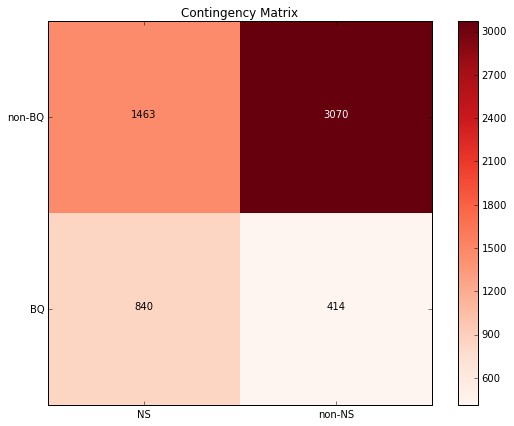

In [28]:
# visualizing the contingency matrix
cm = contingency
fig, ax = plt.subplots(1,1, figsize=(8,6))
cmap = plt.cm.Reds
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Contingency Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['NS', 'non-NS'], rotation=0)
plt.yticks(tick_marks, ['non-BQ', 'BQ'])

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

The BQ quadrants (bottom half/second row) are usually the least populated since it's difficult to BQ (and most marathons have far more non-BQs than BQs).

At most marathons, the bottom left quadrant (NS BQs) is usually the least populated, by a long shot. Not at St George!

Because the chi-squared value is much greater than the critical value at the 99% confidence level (~500 >> 6.635), we can reject the null hypothesis that splits and BQs are uncorrelated.

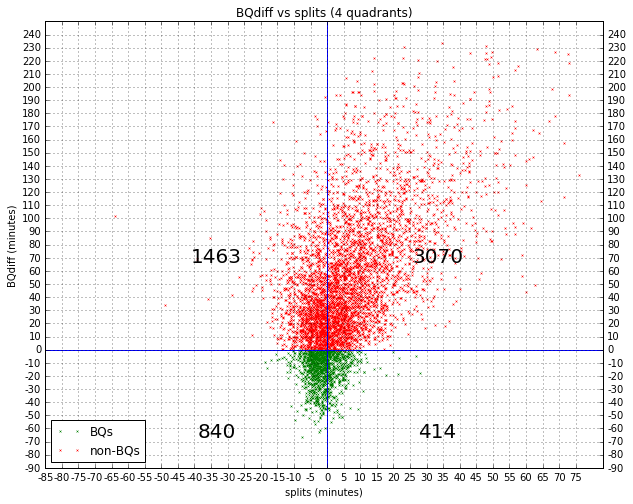

In [29]:
# BQdiff vs splits: visualizing the spread of points across the 4 quadrants
plotthis = True
if plotthis == True:
    fig, ax = plt.subplots(1,1, figsize=(10,8))

    ploty = dfr.query("BQ==1")['BQdiff']
    plotx = dfr.query("BQ==1")['splits']
    ax.plot(plotx,ploty, 'gx', aa=True, markersize=2, label='BQs')

    ploty = dfr.query("BQ==0")['BQdiff']
    plotx = dfr.query("BQ==0")['splits']
    ax.plot(plotx,ploty, 'rx', aa=True, markersize=2, label='non-BQs')

    # ns_bq_y, ns_bq_n, ps_bq_y, ps_bq_n
    plt.text(-2000, -4000, ns_bq_y, size=20, horizontalalignment='center')
    plt.text(-2000, 4000, ns_bq_n, size=20, horizontalalignment='center')
    plt.text(2000, -4000, ps_bq_y, size=20, horizontalalignment='center')
    plt.text(2000, 4000, ps_bq_n, size=20, horizontalalignment='center')
    plt.xlabel("splits (minutes)")
    plt.ylabel("BQdiff (minutes)")
    xlim_range = [-5000, 5000]; ylim_range = [-5000,15000]
    plt.xlim(xlim_range)
    plt.ylim(ylim_range)
    plt.xticks([x*60*5 for x in range(int(np.floor(min(xlim_range)/300.0)),int(np.ceil(max(xlim_range))/300.0))],[x*5 for x in range(int(np.floor(min(xlim_range)/300.0)),int(np.ceil(max(xlim_range))/300.0))])
    plt.yticks([x*60*10 for x in range(int(np.floor(min(ylim_range)/600.0)),int(np.ceil(max(ylim_range))/600.0))],[x*10 for x in range(int(np.floor(min(ylim_range)/600.0)),int(np.ceil(max(ylim_range))/600.0))])
    ax.tick_params(labeltop=False, labelright=True)
    plt.axhline()
    plt.axvline()
    plt.legend(loc='lower left')
    plt.grid(axis='both')
    plt.title('BQdiff vs splits (4 quadrants)')
    plt.show()

### Pace-related queries

In [30]:
# query: find those who had a split pace that was more than X seconds faster than their overall pace
delta = 45 # seconds
columns_i_want = ['BQ','bib','name','age','chip',halfway,'2ndhalf','pace','mm','non_missing_splitpaces_time','stdpace']
dfr[dfr.apply(lambda row: ((min(row['non_missing_splitpaces']) + delta) 
    < get_sec(row['pace'])),axis=1) == 1].query("BQ==1").sort_values(by='stdpace',ascending=False)[0:10][columns_i_want]

,BQ,bib,name,age,chip,split2_time,2ndhalf,pace,mm,non_missing_splitpaces_time,stdpace
3443,1,6912,HELEN G MCMAHAN,60,4:20:00,1:56:33,2:23:27,9:55,[],"[7:52, 9:48, 9:35, 11:56]",99.841259
920,1,5011,JULIE C ESPLIN,40,3:26:55,1:29:26,1:57:29,7:54,[],"[6:28, 7:09, 7:20, 10:09]",97.615020
1338,1,5285,HEIDI S PETERS,44,3:36:13,1:37:24,1:58:49,8:15,[],"[6:56, 7:53, 7:54, 9:55]",75.297262
799,1,205,CARL L HANSON,49,3:23:53,1:31:05,1:52:48,7:47,[],"[6:33, 7:19, 7:31, 9:24]",72.796765
373,1,201,TRAVIS L MILLER,38,3:08:28,1:24:17,1:44:11,7:11,[],"[6:01, 6:48, 7:10, 8:31]",62.797755
2836,1,2540,RICHARD R PLEET,72,4:05:25,1:53:48,2:11:37,9:22,[],"[8:20, 9:00, 9:11, 10:40]",59.222154
2657,1,5935,DENISE LANDVATTER,58,4:00:33,2:09:34,1:50:59,9:10,[],"[10:15, 9:33, 8:19, 8:35]",53.767940
2678,1,1915,RON E SEAMONS,66,4:01:21,1:55:47,2:05:34,9:12,[],"[8:00, 9:35, 9:01, 10:00]",51.637559
1599,1,1016,WILLIAM A BARKER,60,3:41:08,1:42:36,1:58:32,8:26,[],"[7:26, 8:11, 8:27, 9:29]",50.692035
706,1,5231,AUBREE A HUNTER,31,3:20:48,1:49:24,1:31:24,7:40,[],"[8:08, 8:32, 6:46, 7:07]",49.944907


In [31]:
# query: find those who had a split pace that was faster than X minutes
pace_in_sec = 60*5 # pace in seconds/mile
columns_i_want = ['BQ','bib','name','age','chip','pace',halfway,'2ndhalf','mm','non_missing_splitpaces_time','stdpace']
dfr[dfr.apply(lambda row: (min(row['non_missing_splitpaces']) < pace_in_sec),axis=1) == 1][columns_i_want]

,BQ,bib,name,age,chip,pace,split2_time,2ndhalf,mm,non_missing_splitpaces_time,stdpace
2,1,2,JONATHAN KOTTER,28,2:20:50,5:22,1:12:57,1:07:53,[],"[5:22, 5:44, 4:59, 5:19]",18.6011


In [32]:
# check all paces for select people
columns_i_want = ['BQ','bib', 'name', 'age','BQreq','chip',halfway,'2ndhalf','mm',
                  'pace','non_missing_splitpaces_time','stdpace']

# it's possible to BQ with stdpace over X!! 
dfr[dfr['BQ'].isin([1]) & dfr['mm_len'].isin([0])].sort_values(by=['mm_len','stdpace'],ascending=False)[columns_i_want][0:10]

,BQ,bib,name,age,BQreq,chip,split2_time,2ndhalf,mm,pace,non_missing_splitpaces_time,stdpace
3443,1,6912,HELEN G MCMAHAN,60,4:25:00,4:20:00,1:56:33,2:23:27,[],9:55,"[7:52, 9:48, 9:35, 11:56]",99.841259
920,1,5011,JULIE C ESPLIN,40,3:45:00,3:26:55,1:29:26,1:57:29,[],7:54,"[6:28, 7:09, 7:20, 10:09]",97.615020
1338,1,5285,HEIDI S PETERS,44,3:55:00,3:36:13,1:37:24,1:58:49,[],8:15,"[6:56, 7:53, 7:54, 9:55]",75.297262
799,1,205,CARL L HANSON,49,3:30:00,3:23:53,1:31:05,1:52:48,[],7:47,"[6:33, 7:19, 7:31, 9:24]",72.796765
2719,1,6880,CATHY A SHARGAY,54,4:10:00,4:02:18,2:08:39,1:53:39,[],9:14,"[8:32, 10:58, 8:46, 8:36]",70.428723
373,1,201,TRAVIS L MILLER,38,3:10:00,3:08:28,1:24:17,1:44:11,[],7:11,"[6:01, 6:48, 7:10, 8:31]",62.797755
2836,1,2540,RICHARD R PLEET,72,4:25:00,4:05:25,1:53:48,2:11:37,[],9:22,"[8:20, 9:00, 9:11, 10:40]",59.222154
2657,1,5935,DENISE LANDVATTER,58,4:10:00,4:00:33,2:09:34,1:50:59,[],9:10,"[10:15, 9:33, 8:19, 8:35]",53.767940
421,1,5014,TARALYN SUMMERS,31,3:35:00,3:10:41,1:30:31,1:40:10,[],7:16,"[6:32, 7:14, 6:34, 8:26]",53.138314
2678,1,1915,RON E SEAMONS,66,4:10:00,4:01:21,1:55:47,2:05:34,[],9:12,"[8:00, 9:35, 9:01, 10:00]",51.637559


### Runners ahead or behind of BQ pace at all timing mats

Here, we're looking at the number of people who are ahead or behind (in terms of BQ pace) at the timing mats who *eventually fade from BQ pace or "come back" to BQ*.

A BQ runner will show up in one of the *_BQ* columns. He might go from *ahead_BQ* at timing mat #1, to *behind_BQ* at timing mat #2, to *unknown_BQ* at timing mat #3, but he would never add to the *_fade* tallies. In every row, the sum of *ahead_BQ, behind_BQ, unknown_BQ* will always equal the total number of BQs at the race.

(*unknown_BQ* and *u_fade* reflect the number of BQs and non-BQs who have missing splits at that timing mat location.)

By the same logic, a non-BQ runner will always appear under one of the *_fade* columns. The "fade" part isn't entirely accurate, as those who start behind BQ pace and stay behind never actually "fade". Here, I'm using "fade" as a synonym for "non-BQ".

In [33]:
# breakdown of those ahead/behind pace at timing mats
df = dfr
location = []
ahead_pace = []; ahead_fade = []
behind_pace = []; behind_fade = []
unknown_pace = []; unknown_fade = []
for i in timingmats.keys()[0:-1]:
    text = 'split' + str(i) + '_score'
    location.append(timingmats[i])
    ahead_pace.append(df[df[text] <= 0]['BQ'].sum())
    behind_pace.append(df[df[text] > 0]['BQ'].sum())
    unknown_pace.append(df[df[text].isnull()]['BQ'].sum())
    ahead_fade.append(len(df[df[text] <= 0].query("BQ==0")))
    behind_fade.append(len(df[df[text] > 0].query("BQ==0")))
    unknown_fade.append(len(df[df[text].isnull()].query("BQ==0")))
d = {'location': location, 'ahead_BQ': ahead_pace, 'behind_BQ': behind_pace, 'unknown_BQ': unknown_pace,
    'a_fade': ahead_fade, 'b_fade': behind_fade, 'u_fade': unknown_fade}
cols = ['location','ahead_BQ','behind_BQ','unknown_BQ','a_fade','b_fade','u_fade']
BQbreakdown = pd.DataFrame(d, columns=cols, index=range(1,len(mats)))
BQbreakdown['behind_BQpct'] = BQbreakdown.apply(lambda row: "{:.3%}".format(row['behind_BQ']*1.0/dfr['BQ'].sum()),axis=1)
BQbreakdown['a_fadepct'] = BQbreakdown.apply(lambda row: "{:.3%}".format(row['a_fade']*1.0/(row['ahead_BQ']+row['a_fade'])),axis=1)
BQbreakdown['BQoptimal'] = BQbreakdown.apply(lambda row: "{:.3%}".format((dfr.BQ.sum()+row['a_fade'])*1.0/len(dfr)),axis=1)
BQbreakdown['movement'] = BQbreakdown.apply(lambda row: "{:.3%}".format((row['behind_BQ']+row['a_fade'])*1.0/(row['ahead_BQ']+row['behind_BQ']+row['a_fade']+row['b_fade'])),axis=1)
BQbreakdown

,location,ahead_BQ,behind_BQ,unknown_BQ,a_fade,b_fade,u_fade,behind_BQpct,a_fadepct,BQoptimal,movement
1,6.213712,1218,37,3,542,3994,24,2.941%,30.795%,30.938%,9.998%
2,13.109375,1113,141,4,129,4404,27,11.208%,10.386%,23.840%,4.666%
3,18.641136,1220,34,4,146,4396,18,2.703%,10.688%,24.132%,3.106%


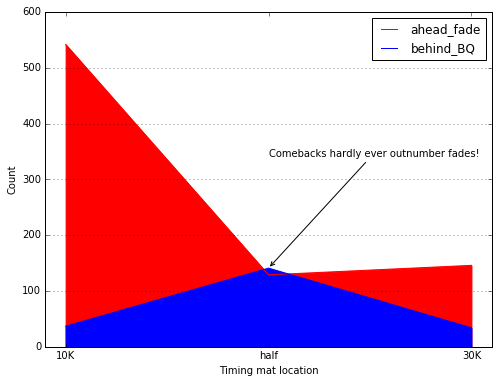

In [34]:
# plotting comebacks & fades
BQbreakdown.a_fade.plot(kind='area',label='ahead_fade',figsize=(8,6), color='r',alpha=1)
BQbreakdown.behind_BQ.plot(kind='area',label='behind_BQ',alpha=1)
plt.xlim([0.9, 3.1])
ax = plt.axes()
text = "Comebacks hardly ever outnumber fades!"
ax.annotate(text, xy=(halfway_index+1, BQbreakdown['behind_BQ'][2]), xytext=(halfway_index+1, BQbreakdown['behind_BQ'][2]+200),
    arrowprops=dict(arrowstyle="->"))
plt.xticks(BQbreakdown.index,['10K','half','30K'])
plt.legend()
plt.xlabel("Timing mat location")
plt.ylabel('Count')
plt.grid(which='both',axis='y')
plt.show()

This never happens -- the number of comebacks at halfway outnumbering the number of fades. Only at 2013 St George!

### Magnitude of negative splits

Not only does SG have a high NS%, but the magnitude of the negative splits are astounding.

Here, we look at the biggest negative splits for BQs.

We see that the top 10 negative splits are all greater than 12 minutes!

In [35]:
# biggest negative splits for BQs
columns_i_want = ['BQ','bib', 'name', 'age','chip',halfway,'2ndhalf','behindby',
    'splits_t','BQdiff_t', 'mm','stdpace','non_missing_splitpaces_time']
(dfr.assign(behindby=map(get_time,dfr[halfway.replace("time","score")]*mats[halfway_index]),splits_t=map(get_time,dfr.splits),BQdiff_t=map(get_time,dfr.BQdiff))\
     .query("BQ==1").sort_values(by='splits',ascending=True)[columns_i_want].head(10))

,BQ,bib,name,age,chip,split2_time,2ndhalf,behindby,splits_t,BQdiff_t,mm,stdpace,non_missing_splitpaces_time
2657,1,5935,DENISE LANDVATTER,58,4:00:33,2:09:34,1:50:59,4:34,-18:35,-9:27,[],53.767940,"[10:15, 9:33, 8:19, 8:35]"
706,1,5231,AUBREE A HUNTER,31,3:20:48,1:49:24,1:31:24,1:54,-18:00,-14:12,[],49.944907,"[8:08, 8:32, 6:46, 7:07]"
932,1,5257,MELISSA R GUNNER,22,3:27:16,1:52:03,1:35:13,4:33,-16:50,-7:44,[],47.209081,"[8:10, 8:54, 7:18, 7:14]"
1354,1,1735,CHULSUB SONG,54,3:36:30,1:55:55,1:40:35,5:55,-15:20,-3:30,[],42.593466,"[9:01, 8:41, 7:33, 7:46]"
2719,1,6880,CATHY A SHARGAY,54,4:02:18,2:08:39,1:53:39,3:39,-15:00,-7:42,[],70.428723,"[8:32, 10:58, 8:46, 8:36]"
2731,1,3703,G MARSDEN BLANCH,66,4:02:36,2:08:31,1:54:05,3:31,-14:26,-7:24,[],38.129868,"[9:50, 9:46, 8:53, 8:35]"
268,1,74,DAVID C BELL,37,3:03:48,1:38:40,1:25:08,3:40,-13:32,-6:12,[],35.607878,"[7:29, 7:33, 6:39, 6:23]"
1230,1,1267,MARK J THURBER,58,3:34:04,1:53:36,1:40:28,3:36,-13:08,-5:56,[],34.766684,"[8:33, 8:47, 7:46, 7:35]"
1175,1,5631,KELLIE TAYLOR,36,3:32:53,1:52:36,1:40:17,2:36,-12:19,-7:07,[],34.656039,"[8:30, 8:41, 7:27, 7:48]"
1724,1,5401,REBECCA D KANDT,45,3:43:28,1:57:48,1:45:40,0:18,-12:08,-11:32,[],33.066223,"[8:50, 9:08, 8:00, 8:07]"


### BQ misses (close calls)

In [36]:
# people who faded from BQs at halfway (sorted by closest misses)
columns_i_want = ['name','age','BQreq','chip','BQdiff_t',halfway,'2ndhalf','splits_t','aheadby','stdpace','mm','non_missing_splitpaces_time']
dfr.assign(splits_t=map(get_time,dfr.splits), BQdiff_t=map(get_time,dfr.BQdiff), aheadby=map(get_time,-dfr[halfway.replace("time","score")]*mats[halfway_index]))\
    [dfr['BQ'].isin([0]) & (dfr[halfway.replace("time","score")]<=0)].sort_values(by='BQdiff')[columns_i_want]

,name,age,BQreq,chip,BQdiff_t,split2_time,2ndhalf,splits_t,aheadby,stdpace,mm,non_missing_splitpaces_time
2624,TIA ASTLE,51,4:00:00,4:00:03,0:03,1:58:30,2:01:33,3:03,1:30,38.570913,[],"[8:15, 9:45, 9:07, 9:23]"
1801,TIFFANI A THOMAS,40,3:45:00,3:45:05,0:05,1:49:08,1:55:57,6:49,3:22,32.755672,[],"[7:57, 8:40, 8:19, 9:14]"
857,SHANE MCMILLAN,44,3:25:00,3:25:06,0:06,1:40:53,1:44:13,3:20,1:37,35.008649,[],"[7:24, 7:58, 7:12, 8:30]"
413,NATE ROCKWELL,37,3:10:00,3:10:06,0:06,1:32:31,1:37:35,5:04,2:29,33.525514,[],"[6:36, 7:28, 6:54, 7:50]"
293,CLINT D SATTERTHWAITE,29,3:05:00,3:05:14,0:14,1:31:25,1:33:49,2:24,1:05,19.580651,[],"[6:51, 7:05, 6:44, 7:28]"
1564,BRENT L ANDERSON,57,3:40:00,3:40:14,0:14,1:49:28,1:50:46,1:18,0:32,20.757956,[],"[8:06, 8:34, 8:03, 8:45]"
4582,MARY E YOUNG,70,4:55:00,4:55:16,0:16,2:19:06,2:36:10,17:04,8:24,65.287658,[],"[9:50, 11:19, 11:08, 12:29]"
538,JOHN D KAYSER,42,3:15:00,3:15:17,0:17,1:35:57,1:39:20,3:23,1:33,23.443987,[],"[6:54, 7:42, 7:21, 7:44]"
296,JACOB A ANDERSON,30,3:05:00,3:05:18,0:18,1:31:01,1:34:17,3:16,1:29,20.200525,[],"[6:38, 7:13, 6:55, 7:24]"
540,ANTHONY E KIMBALL,40,3:15:00,3:15:20,0:20,1:34:47,1:40:33,5:46,2:43,33.190538,[],"[6:41, 7:43, 7:18, 7:57]"


In [37]:
# these are the runners classified as "easy" who missed their BQs by the least
columns_i_want = ['BQ','name','age','BQreq','chip','BQdiff_t','pace',tenK.replace("time","score"),halfway.replace("time","score"),halfway,'2ndhalf','splits_t','behindby','stdpace','mm','non_missing_splitpaces_time']
easy.assign(splits_t=map(get_time,easy.splits),BQdiff_t = map(get_time,easy.BQdiff),behindby=map(get_time,easy[halfway.replace("time","score")]*mats[halfway_index])).sort_values(by='BQdiff').head(10)[columns_i_want]

,BQ,name,age,BQreq,chip,BQdiff_t,pace,split1_score,split2_score,split2_time,2ndhalf,splits_t,behindby,stdpace,mm,non_missing_splitpaces_time
1287,0,MELISSA BURTON,30,3:35:00,3:35:15,0:15,8:13,25.228852,18.002384,1:51:26,1:43:49,-7:37,3:56,22.566039,[],"[8:37, 8:24, 7:47, 8:01]"
1289,0,REBECCA M TOLLEFSON,23,3:35:00,3:35:17,0:17,8:13,26.194459,31.351609,1:54:21,1:40:56,-13:25,6:51,36.734873,[],"[8:38, 8:48, 7:33, 7:48]"
299,0,DEREK CICCHITTO,31,3:05:00,3:05:29,0:29,7:04,9.391452,26.851013,1:38:22,1:27:07,-11:15,5:52,32.565427,[],"[7:13, 7:46, 6:35, 6:41]"
2402,0,YUMI SHIMIZU,47,3:55:00,3:55:44,0:44,8:59,26.935727,33.029797,2:04:43,1:51:01,-13:42,7:13,37.946095,[],"[9:25, 9:36, 8:17, 8:36]"
1319,0,HEATHER STOUT,32,3:35:00,3:35:46,0:46,8:14,25.228852,13.120381,1:50:22,1:45:24,-4:58,2:52,23.014894,[],"[8:37, 8:14, 7:42, 8:18]"
4191,0,KARIN L ROWLEY,68,4:40:00,4:41:03,1:03,10:43,-19.716971,27.232420,2:25:57,2:15:06,-10:51,5:57,48.823310,[],"[10:21, 11:50, 9:57, 10:34]"
2677,0,CHERYL CORBETT,51,4:00:00,4:01:20,1:20,9:12,7.607749,27.842670,2:06:05,1:55:15,-10:50,6:05,33.804945,[],"[9:17, 9:55, 8:36, 8:56]"
561,0,WAYNE B JOHNSON,41,3:15:00,3:16:23,1:23,7:29,9.681619,26.774732,1:43:21,1:33:02,-10:19,5:51,30.484669,[],"[7:36, 8:08, 7:00, 7:10]"
563,0,MYRON J BOUWHUIS,40,3:15:00,3:16:24,1:24,7:29,9.681619,26.774732,1:43:21,1:33:03,-10:18,5:51,30.457394,[],"[7:36, 8:08, 7:00, 7:10]"
445,0,ROMULUS I PASCA,36,3:10:00,3:11:49,1:49,7:19,6.317848,20.824791,1:39:33,1:32:16,-7:17,4:33,21.861431,[],"[7:21, 7:49, 7:06, 6:59]"


###  Missing splits (timing mat anomalies)

Timing mats don't always detect runners' RFID tags as they go by.

Different races have varying degrees of timing mats not detecting runners. At SG, this isn't a widespread issue.

Even if SG runners don't record a split or two, it's unlikely that they cut the course, due to the race's point-to-point, downhill nature.

Here, we take a look at the numbers of missing splits, where they occurred, and which BQ runners had missing splits.

By now, you've probably figured out that "mm" stands for "missing mats", and "mm_len" represents len(mm). If a runner has mm = [1], that means that she has a missing first split.

In [38]:
# missing mats
print(dfr['mm_len'].value_counts().sort_index())
print(len(dfr[dfr.mm_len>0]))
print("{:.2%} of {} finishers had at least 1 missing split".format(len(dfr[dfr.mm_len>0])*1.0/len(dfr), len(dfr)))

0    5765
1      35
2       9
3       9
Name: mm_len, dtype: int64
53
0.91% of 5818 finishers had at least 1 missing split


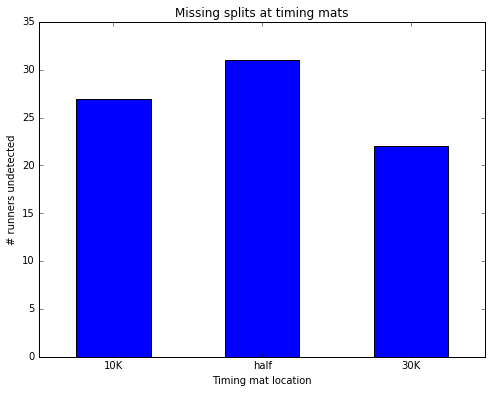

In [39]:
#plt.style.use("default") # default, classic, seaborn-white, ggplot, fivethirtyeight, ...
missingmats_dict = {}
for x in range(1,len(timingmats)):
    missingmats_dict[timingmats[x]] = dfr.apply(lambda row: 1 if x in row['mm'] else 0,axis=1).sum()
pd.Series(missingmats_dict).plot.bar(rot=0, figsize=(8,6))
plt.xlabel("Timing mat location")
plt.ylabel("# runners undetected")
plt.title("Missing splits at timing mats")
plt.xticks(range(3), ['10K','half','30K'])
plt.show()

In [40]:
# check all paces for BQs with missing splits
columns_i_want = ['BQ','bib', 'name', 'age','BQreq','chip',halfway,'2ndhalf','mm',
                  'pace','non_missing_splitpaces_time','stdpace']

(dfr[dfr['BQ'].isin([1]) & (dfr['mm_len']>0)].sort_values(by=['mm_len','stdpace'],ascending=False)[columns_i_want][0:])

,BQ,bib,name,age,BQreq,chip,split2_time,2ndhalf,mm,pace,non_missing_splitpaces_time,stdpace
1920,1,2557,G BRENT WYNN,75,4:40:00,3:47:33,,,"[1, 2, 3]",8:41,[8:41],NaN
1930,1,5335,CHRISTINE M ESCHLER,47,3:55:00,3:47:40,1:48:42,1:58:58,[3],8:41,"[7:48, 8:44, 9:04]",39.613488
2934,1,7332,ROCHELLE MILES,55,4:10:00,4:08:13,,,[2],9:28,"[8:56, 9:32, 9:48]",26.253092
3072,1,3373,ROBERT P BRADSHAW,70,4:25:00,4:11:21,2:06:41,2:04:40,[1],9:35,"[9:40, 9:02, 9:52]",26.041023
571,1,5350,PHAEDRA M KILBOURN,43,3:45:00,3:16:39,1:41:28,1:35:11,[1],7:30,"[7:44, 7:01, 7:26]",21.686226
1022,1,5524,CANDICE MACFARLANE,37,3:40:00,3:29:17,1:44:20,1:44:57,[3],7:59,"[7:35, 8:17, 8:00]",21.106199
380,1,824,AHMED M ABOU-ZAMZAM,47,3:25:00,3:08:39,1:32:24,1:36:15,[3],7:12,"[6:45, 7:19, 7:21]",20.432250
764,1,5523,KRYSTAL HAWKER,39,3:45:00,3:22:54,,,[2],7:44,"[7:35, 7:43, 7:54]",9.640452
800,1,5295,KRYSTINA S HAWRYLUK,34,3:40:00,3:23:59,,,[2],7:47,"[7:36, 7:48, 7:54]",9.249851


### Miscellaneous

In [41]:
dfr.assign(gunchipdiff = pd.to_datetime(dfr.gun,format="%H:%M:%S") - pd.to_datetime(dfr.chip,format="%H:%M:%S"))\
    .sort_values(by='gunchipdiff',ascending=False).head(30)[['BQ','bib','name','age','gun','chip','mm','non_missing_splitpaces_time','gunchipdiff']]
# Here, we're sorting the results by people who started the race the latest.
# Many large marathons have "wave" starts and release people in groups (by goal pace).
# I'm not sure about SG's wave setup.
# But here we see that the person who started last, by a good 18 minutes from
# the penultimate starter, managed to BQ.

,BQ,bib,name,age,gun,chip,mm,non_missing_splitpaces_time,gunchipdiff
2358,1,4362,WILLIE F MUNDT,64,4:36:56,3:55:01,[],"[7:57, 9:12, 8:42, 9:46]",00:41:55
3927,0,2323,DAREN J DAVIS,48,4:56:18,4:32:16,[],"[9:28, 10:09, 10:20, 11:23]",00:24:02
4222,0,2187,JUSTIN T ROBINS,38,5:06:14,4:42:23,[],"[9:12, 10:01, 9:57, 13:20]",00:23:51
2518,0,2141,ALAN B RASMUSSEN,52,4:21:39,3:57:49,[],"[9:17, 9:24, 8:29, 9:02]",00:23:50
2086,0,2244,JEFFREY A JONES,42,4:14:02,3:50:14,[],"[8:49, 9:32, 8:29, 8:17]",00:23:48
4321,0,3224,ERIC K ASIEDU,49,5:09:43,4:46:01,[],"[8:49, 11:09, 9:54, 13:08]",00:23:42
1935,0,5982,ANDREA BIRD,41,4:11:21,3:47:43,[],"[8:16, 9:21, 8:05, 8:52]",00:23:38
5422,0,7987,JULIE BLATTER,39,6:08:50,5:45:12,[],"[11:53, 12:38, 13:31, 14:27]",00:23:38
5423,0,8116,KAREN LITTLE,34,6:08:49,5:45:12,[],"[11:53, 12:38, 13:31, 14:26]",00:23:37
3988,0,2509,LYNN VAN ROOSENDAAL,55,4:57:53,4:34:17,[],"[8:40, 10:29, 10:51, 11:37]",00:23:36


In [42]:
# find runners who ran together the whole way (same cumulative paces at all splits)
# chip times can be slightly different at all timing mats (paces are averaged out by differences)

paces = ['split' + str(x) + "_pace" for x in range(1,len(mats)) ] + ['pace']
subset = dfr[paces]
columns_i_want = ['BQ','bib','name','DIVISION','city','chip'] + paces
print(len(dfr[subset.duplicated(keep=False)])) # X such runners
(dfr[subset.duplicated(keep=False)][columns_i_want].head(20))

532


,BQ,bib,name,DIVISION,city,chip,split1_pace,split2_pace,split3_pace,pace
156,1,356,MICHAEL MCDERMOTT,M45_49,"FREDERICKSBURG, VA",2:57:49,6:33,6:50,6:44,6:47
162,1,208,ANDY IORG,M35_39,"SOUTH JORDAN, UT",2:57:53,6:33,6:50,6:44,6:47
402,1,630,BUCKLEY WINFREE,M35_39,"MURFREESBORO, TN",3:09:33,7:19,7:23,7:14,7:14
406,1,720,LEE M GOLDEN,M40_44,"MURFREESBORO, TN",3:09:36,7:19,7:23,7:14,7:14
561,0,1062,WAYNE B JOHNSON,M40_44,"WEST POINT, UT",3:16:23,7:36,7:53,7:37,7:29
563,0,924,MYRON J BOUWHUIS,M40_44,"WEST POINT, UT",3:16:24,7:36,7:53,7:37,7:29
601,0,485,CORY P BEYNON,M35_39,"KAYSVILLE, UT",3:17:32,6:58,7:14,7:14,7:32
604,0,713,SCOTT W BEYNON,M35_39,"KAYSVILLE, UT",3:17:38,6:58,7:14,7:14,7:32
746,0,941,CRISMON B TURNER,M25_29,"NEWPORT BEACH, CA",3:22:11,7:55,7:59,7:50,7:43
748,0,1398,LOGAN B PRINCE,M20_24,"SALT LAKE, UT",3:22:12,7:55,7:59,7:50,7:43


In [43]:
# find specific entrants
dfr[dfr.name.str.contains("metler",case=False)][['BQ','bib','name','age','chip',halfway,'2ndhalf','mm','non_missing_splitpaces_time','stdpace']+paces]

,BQ,bib,name,age,chip,split2_time,2ndhalf,mm,non_missing_splitpaces_time,stdpace,split1_pace,split2_pace,split3_pace,pace
5,1,4,AARON J METLER,29,2:22:29,1:12:01,1:10:28,[],"[5:20, 5:38, 5:16, 5:27]",9.497037,5:20,5:30,5:26,5:26
390,0,234,DAVID METLER,26,3:09:05,1:29:34,1:39:31,[],"[6:29, 7:09, 7:06, 7:57]",36.247515,6:29,6:50,6:55,7:13


0       9
1      32
2    3304
3      91
4    2382
Name: biggestslowdown, dtype: int64


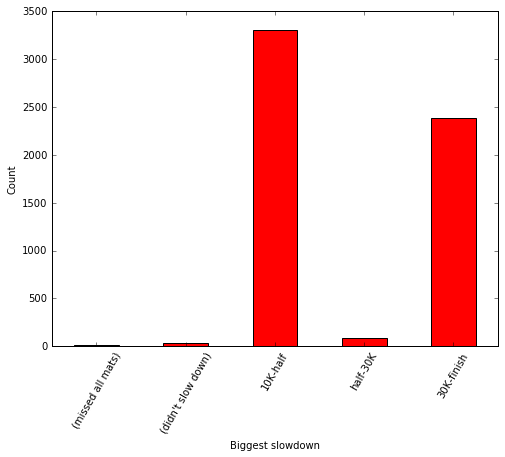

In [44]:
# which race segment caused the biggest slowdown?
print(dfr['biggestslowdown'].value_counts().sort_index())
dfr['biggestslowdown'].value_counts().sort_index().plot.bar(figsize=(8,6),rot=60,color='r')
plt.xlabel('Biggest slowdown')
plt.ylabel('Count')
plt.xticks(range(0,len(mats)+1),['(missed all mats)',"(didn't slow down)",'10K-half','half-30K','30K-finish'])
plt.show()

0       9
1     125
2    2581
3     165
4    2938
Name: slowest_split, dtype: int64


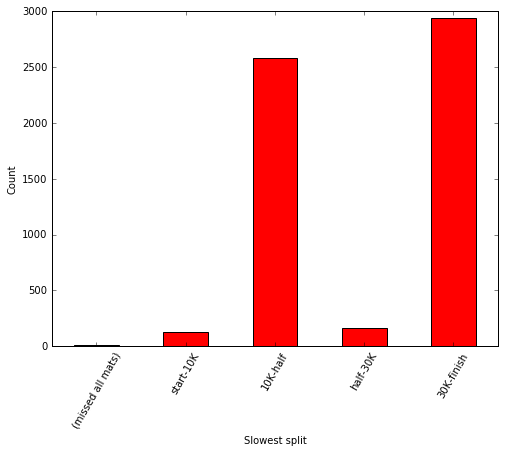

In [45]:
# which segment did people run the slowest?
# Note that this isn't the same as "biggest slowdown" above.
# "biggest slowdown" looks at the runner's split pace between consecutive segments.
# So, it's entirely possible that 10K-half caused a runner to slow down the most, while 
#  30K-finish was his slowest split.
#  (Example: non_missing_splitpaces_time=[7:00, 7:30, 7:31, 7:32])
print(dfr['slowest_split'].value_counts().sort_index())
dfr['slowest_split'].value_counts().sort_index().plot.bar(figsize=(8,6),rot=60,color='r')
plt.xlabel('Slowest split')
plt.ylabel('Count')
plt.xticks(range(0,len(mats)+1),['(missed all mats)',"start-10K",'10K-half','half-30K','30K-finish'])
plt.show()

###  Boston registrants from this race (those who qualified and registered for 2015 Boston)

In [46]:
# First, find BQs by people who might "age up" between this race & qualifying BOS race
# These are people who have BQ==0 but still might have BQed depending on their birthdate
# For example, a 33-year-old (in OCT 2013) with a March birthdate will be 35 in APR 2015
# So, we're trying to find "possible BQs" who are assumed to be non-BQs

columns_i_want = ['name','age','DIVISION','BQreq','chip',halfway,'2ndhalf','mm','non_missing_splitpaces_time','stdpace']
offset = 1+ageUp

possibles1 = dfr[(dfr['age'].isin((x-offset) for x in [35,40,50])) & (dfr['BQdiff'] <= 60*5) & (dfr['BQ'] == 0) ]
possibles2 = dfr[(dfr['age'].isin((x-offset) for x in [45,55])) & (dfr['BQdiff'] <= 60*10) & (dfr['BQ'] == 0) ]
possibles3 = dfr[(dfr['age'].isin((x-offset) for x in [60,65,70,75])) & (dfr['BQdiff'] <= 60*15) & (dfr['BQ'] == 0) ]
print(len(possibles1))
print(len(possibles2))
print(len(possibles3))
possibles = pd.concat([possibles1,possibles2,possibles3])
possibles.sort_values(by=['mm_len','stdpace'],ascending=False)[columns_i_want]

17
18
11


,name,age,DIVISION,BQreq,chip,split2_time,2ndhalf,mm,non_missing_splitpaces_time,stdpace
4191,KARIN L ROWLEY,68,F65_69,4:40:00,4:41:03,2:25:57,2:15:06,[],"[10:21, 11:50, 9:57, 10:34]",48.823310
1763,BRUCE D HATATHLI,58,M55_59,3:40:00,3:44:26,1:45:50,1:58:36,[],"[7:49, 8:18, 8:12, 9:40]",48.679101
1984,JOEY BRITO,58,M55_59,3:40:00,3:48:31,1:51:51,1:56:40,[],"[7:56, 9:05, 8:02, 9:32]",47.145910
4508,LOLA E ACKERMAN,68,F65_69,4:40:00,4:51:54,2:20:44,2:31:10,[],"[10:38, 10:50, 10:40, 12:10]",43.913639
3205,DAWN N VONDERHEIDE,58,F55_59,4:10:00,4:14:20,2:03:39,2:10:41,[],"[9:01, 9:49, 9:10, 10:33]",41.935127
2154,TIMOTHY J ETTRIDGE,58,M55_59,3:40:00,3:51:18,1:50:49,2:00:29,[],"[7:57, 8:55, 8:38, 9:36]",41.080276
1432,STEVEN HOWARD,53,M50_54,3:30:00,3:37:53,1:44:54,1:52:59,[],"[7:42, 8:17, 7:51, 9:11]",39.985481
529,DUSTIN C ENCE,38,M35_39,3:10:00,3:14:47,1:33:39,1:41:08,[],"[6:50, 7:26, 6:56, 8:17]",39.924647
3311,TOM ROGERS,68,M65_69,4:10:00,4:16:47,2:10:05,2:06:42,[],"[9:10, 10:36, 9:29, 9:48]",37.085321
2046,DEENA N WOLFLEY,43,F40_44,3:45:00,3:49:35,1:53:50,1:55:45,[],"[7:59, 9:19, 8:30, 9:04]",36.153484


In [47]:
# Match the above with the Boston entrants list for the applicable year
df = dfr
offset = 1+ageUp
BOSlist = pd.read_excel("2015bostonentrants.xlsx")
BOSlist = BOSlist[BOSlist['name'].notnull()]
BOSlist['name'] = BOSlist.apply(lambda row: unicodedata.normalize('NFD', row['name']).encode('ascii', 'ignore'),axis=1)
# get rid of middle initial from first names
BOSlist['fname'] = BOSlist.apply(lambda row: row['name'].split(",")[1].replace("Dr.","").strip().split(" ")[0].strip(), axis=1)
BOSlist['lname'] = BOSlist.apply(lambda row: row['name'].split(",")[0].strip(), axis=1)
BOSlist['name_mod'] = BOSlist['fname'].str.upper() + " " + BOSlist['lname'].str.upper()
possibleBQs = pd.concat([df[(df['age'].isin([35-offset,40-offset,50-offset])) & (df['BQdiff'] <= 60*5) & (df['BQ'] == 0) ],
    df[ (df['age'].isin([45-offset,55-offset])) & (df['BQdiff'] <= 60*10) & (df['BQ'] == 0) ],
    df[ (df['age'].isin([60-offset,65-offset,70-offset,75-offset])) & (df['BQdiff'] <= 60*15) & (df['BQ'] == 0) ]])\
    [['bib','name','age','chip','BQreq','BQdiff']]
possibleBQs['name'] = possibleBQs['name'].str.upper().str.replace(' . ',' ')
possibleBQs['BQage'] = (possibleBQs['age'] + offset).apply(int)
registered = pd.merge(possibleBQs, BOSlist, left_on=['name','BQage'], right_on=['name_mod','age']).sort_values(by='chip')
print("{} possible BQs due to age-ing up".format(len(possibleBQs)))
print(len(registered))

46 possible BQs due to age-ing up
10


In [48]:
# check all paces for select people (possible BQs that registered)
columns_i_want = ['BQ','bib', 'name', 'age','BQreq','chip','pace',halfway,'2ndhalf',
                  'mm', 'non_missing_splitpaces_time','stdpace']
print("{} negative splits".format(len(df[ (df['bib'].isin(registered['bib_x'])) ].query("splits<0"))))
(df[ (df['bib'].isin(registered['bib_x'])) ].sort_values(by=['mm_len','stdpace'],ascending=False)[columns_i_want])

5 negative splits


,BQ,bib,name,age,BQreq,chip,pace,split2_time,2ndhalf,mm,non_missing_splitpaces_time,stdpace
1763,0,1588,BRUCE D HATATHLI,58,3:40:00,3:44:26,8:34,1:45:50,1:58:36,[],"[7:49, 8:18, 8:12, 9:40]",48.679101
4508,0,7798,LOLA E ACKERMAN,68,4:40:00,4:51:54,11:08,2:20:44,2:31:10,[],"[10:38, 10:50, 10:40, 12:10]",43.913639
3205,0,6881,DAWN N VONDERHEIDE,58,4:10:00,4:14:20,9:42,2:03:39,2:10:41,[],"[9:01, 9:49, 9:10, 10:33]",41.935127
3311,0,3258,TOM ROGERS,68,4:10:00,4:16:47,9:48,2:10:05,2:06:42,[],"[9:10, 10:36, 9:29, 9:48]",37.085321
1047,0,1091,CRAIG M TERRIEN,48,3:25:00,3:29:49,8:00,1:42:40,1:47:09,[],"[7:38, 8:01, 7:29, 8:41]",32.183959
1196,0,1195,DAVID J LAYTON,53,3:30:00,3:33:14,8:08,1:43:10,1:50:04,[],"[7:39, 8:04, 7:48, 8:50]",31.554787
1684,0,1681,RICHARD PERLOW,58,3:40:00,3:42:52,8:30,1:54:52,1:48:00,[],"[8:40, 8:51, 7:52, 8:30]",25.469688
776,0,846,TYLER L MURRAY,43,3:15:00,3:23:16,7:45,1:41:57,1:41:19,[],"[7:31, 8:01, 7:30, 7:53]",15.581737
550,0,695,ROB TEREN,43,3:15:00,3:15:54,7:28,1:38:48,1:37:06,[],"[7:15, 7:47, 7:18, 7:29]",14.609755
478,0,771,OWEN LILLYWHITE,38,3:10:00,3:13:08,7:22,1:36:49,1:36:19,[],"[7:14, 7:31, 7:10, 7:29]",10.907896


In [49]:
# BQs from this race who registered for qualifying BOS
columns_i_want = ['BQ', 'bib','name', 'age','BQreq','chip','pace',halfway,'2ndhalf',
                  'mm', 'non_missing_splitpaces_time','stdpace']
# this method isn't foolproof -- doesn't match ages, and so common names might get matched
# in other words, names on the Boston list might have matches to SG runners, but they might not be the same people
reg = dfr[dfr['name'].str.replace(' . ',' ').str.upper().isin(BOSlist['name_mod']) & dfr['BQ'].isin([1])]
print len(reg)
reg.sort_values(by=['mm_len','stdpace'],ascending=False)[0:][columns_i_want]
# more complex method that matches on ages --
#reg1 = pd.merge(dfr.assign(name_mod=lambda x: x['name'].str.replace(' . ',' ').str.upper()),BOSlist,on=['name_mod','age'])
#reg2 = pd.merge(dfr.assign(name_mod=lambda x: x['name'].str.replace(' . ',' ').str.upper(),age_up=lambda x: x['age']+1),BOSlist,left_on=['name_mod','age_up'],right_on=['name_mod','age'])
#dfr[(dfr.bib.isin(reg1.bib_x) | dfr.bib.isin(reg2.bib_x)) & dfr['BQ'].isin([1])].sort_values(by=['mm_len','stdpace'],ascending=False)[0:][columns_i_want]

542


,BQ,bib,name,age,BQreq,chip,pace,split2_time,2ndhalf,mm,non_missing_splitpaces_time,stdpace
1022,1,5524,CANDICE MACFARLANE,37,3:40:00,3:29:17,7:59,1:44:20,1:44:57,[3],"[7:35, 8:17, 8:00]",21.106199
380,1,824,AHMED M ABOU-ZAMZAM,47,3:25:00,3:08:39,7:12,1:32:24,1:36:15,[3],"[6:45, 7:19, 7:21]",20.432250
1338,1,5285,HEIDI S PETERS,44,3:55:00,3:36:13,8:15,1:37:24,1:58:49,[],"[6:56, 7:53, 7:54, 9:55]",75.297262
2719,1,6880,CATHY A SHARGAY,54,4:10:00,4:02:18,9:14,2:08:39,1:53:39,[],"[8:32, 10:58, 8:46, 8:36]",70.428723
373,1,201,TRAVIS L MILLER,38,3:10:00,3:08:28,7:11,1:24:17,1:44:11,[],"[6:01, 6:48, 7:10, 8:31]",62.797755
421,1,5014,TARALYN SUMMERS,31,3:35:00,3:10:41,7:16,1:30:31,1:40:10,[],"[6:32, 7:14, 6:34, 8:26]",53.138314
1715,1,2243,THOMAS C DULL,61,3:55:00,3:43:16,8:31,1:47:10,1:56:06,[],"[7:18, 8:58, 8:27, 9:09]",49.813930
3437,1,3392,JACK KIRKS,73,4:25:00,4:19:49,9:55,2:06:54,2:12:55,[],"[8:46, 10:30, 9:44, 10:26]",48.598730
2365,1,5986,SHARON K HOWER,54,4:10:00,3:55:07,8:58,1:52:45,2:02:22,[],"[7:54, 9:14, 8:46, 9:45]",47.361548
1828,1,5757,LISA ABBOTT,45,3:55:00,3:45:42,8:37,1:49:13,1:56:29,[],"[7:36, 8:59, 8:17, 9:19]",45.709751


In [50]:
stop_here

NameError: name 'stop_here' is not defined